In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import math
import gensim.downloader as gd
from torch.utils.data import Dataset, DataLoader
from tokenizers import Tokenizer
from datasets import load_dataset

# Data Preparation

## Tokenizing text

In [2]:
tokenizer = Tokenizer.from_file("/kaggle/input/hindi-english-tokenizer/bpe_tokenizer.json")

In [3]:
encoded = tokenizer.encode("आप कैसे हैं? How are you ?")
print("Tokens:", encoded.tokens)
print("IDs:", encoded.ids)

Tokens: ['आप', 'कैसे', 'हैं', '?', 'how', 'are', 'you', '?']
IDs: [1113, 3750, 904, 37, 1904, 923, 892, 37]


## Transformer Model Implementation

### Embedding Layer

In [4]:
class EmbeddingLayer(nn.Module):
    def __init__(self, vocab_size, d_model):
        super(EmbeddingLayer, self).__init__()
        self.model = nn.Embedding(vocab_size, d_model)

    def forward(self, x):
        return self.model(x)

### Positional Encoding 

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, max_seq_length, d_model):
        super(PositionalEncoding, self).__init__() # skip the positionalEncoding inside super (after python 3)

        matrix = torch.zeros(max_seq_length, d_model)
        val = torch.Tensor([pos / (10000 ** ((2*i) / d_model)) for pos in torch.arange(max_seq_length) for i in torch.arange(0, d_model, 2)]).reshape(max_seq_length, d_model//2)
        matrix[:, 0::2] = torch.sin(val)
        matrix[:, 1::2] = torch.cos(val)

        self.register_buffer('matrix', matrix)

    def forward(self, x):
        seq_len = x.size(1)
        pe = self.matrix[:seq_len, :].unsqueeze(0).to(x.device)  # shape: [1, seq_len, d_model]
        return x + pe

### Self attention block

In [6]:
class SelfAttention(nn.Module):
    def __init__(self, d_model, d_k, d_v):
        super(SelfAttention, self).__init__() 
        self.d_k = d_k
        self.d_v = d_v
        self.d_model = d_model
        
        self.w_q = nn.Linear(d_model, d_k)
        self.w_k = nn.Linear(d_model, d_k)
        self.w_v = nn.Linear(d_model, d_v)

    def forward(self, q, k, v, mask=None):

        q, k, v = self.w_q(q), self.w_k(k), self.w_v(v)

        # score = (q@k.T) / math.sqrt(self.d_k)
        score = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)

        if mask is not None:
            score = score.masked_fill(mask == 0, float('-inf'))

        x = F.softmax(score, dim=-1) @ v 
        return x

We cannot use ``score = (q@k.T) / math.sqrt(self.d_k)`` as per chatGPT. The reason is due to dimensional mismatch. I have assumed that the q, k and v vectors are 2D but in pytorch they are saved as (batch_size, seq_len, d_model). Due to this reason we need to change the above code with `
scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)` code.

### Multi-Head attention block

In [7]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, d_model):
        super(MultiHeadAttention, self).__init__()

        assert d_model % n_heads == 0

        self.n_head = n_heads
        self.d_model = d_model
        self.k = self.v = d_model // n_heads

        self.attentions = nn.ModuleList([SelfAttention(self.d_model, self.k, self.v) for _ in range(n_heads)])
        self.w_o = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        
        x = [attention(q, k, v, mask) for attention in self.attentions]
        x = torch.cat(x, dim=-1)
        
        return self.w_o(x)

I used only list of self attentions. This will cause the weights of those attention blocks to not update during training. This can be solved by wrapping the list of attention blocks around `nn.ModuleList` method.

### FeedForward Network

In [8]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(FeedForward, self).__init__()

        self.layer1 = nn.Linear(d_model, d_ff)
        self.layer2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.ReLU()

    def forward(self,x):
        
        x = self.layer1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.layer2(x)
        
        return x

This is the first place where I have used `dropout`. I need to find other places where I can use this.

### Encoder Block

In [9]:
class Encoder(nn.Module):
    def __init__(self, n_heads, d_model, d_ff, dropout=0.1):
        super(Encoder, self).__init__()

        self.mha = MultiHeadAttention(n_heads, d_model)
        self.layernorm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)

        self.feedforward = FeedForward(d_model, d_ff)
        self.layernorm2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # MHA and (Skip + layernorm)
        x = self.layernorm1(x + self.dropout1(self.mha(x, x, x, mask)))

        # FeedForward and (Skip + layernorm)
        x = self.layernorm2(x + self.dropout2(self.feedforward(x)))
        
        return x

1. I changed the forward method from `forward(self, x)` -> `forward(self, x, mask=None)` as suggested by the chatGPT.
2. Applied `Dropout` layer after `MHA` and `FeedForward` blocks.

### Decoder Block

In [10]:
class Decoder(nn.Module):
    def __init__(self, n_heads, d_model, d_ff, dropout=0.1):
        super(Decoder, self).__init__()

        self.masked_mha = MultiHeadAttention(n_heads, d_model)
        self.layernorm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        
        self.mha = MultiHeadAttention(n_heads, d_model)
        self.layernorm2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)
        
        self.ff = FeedForward(d_model, d_ff)
        self.layernorm3 = nn.LayerNorm(d_model)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x_encoder, x_prev, mask=None):

        B, T, _ = x_prev.size()

        # masked mha + add & norm
        mask = self.generate_casual_mask(T).to(x_prev.device)
        
        x = self.layernorm1(x_prev + self.dropout1(self.masked_mha(x_prev, x_prev, x_prev, mask)))

        # encoder mha + add & norm
        x = self.layernorm2(x + self.dropout2(self.mha(x, x_encoder, x_encoder)))

        # feedforward + add & norm
        x = self.layernorm3(x + self.dropout3(self.ff(x)))
        
        return x

    def generate_casual_mask(self, size):
        mask = torch.tril(torch.ones(size, size)).bool()
        return mask

1. Added `Dropout` layers.
2. created `generate_casual_mask` function to create mask

### Transformer Implementation 

In [11]:
class MyTransformer(nn.Module):
    def __init__(self, 
                 vocab_size, # total words in the embedding matrix
                 max_seq_len, # max words at a time
                 d_model, # embedding dimension
                 n_encoder, # number of encoders
                 n_decoder, # number of decoders
                 n_heads,  # for multi_head_attention block
                 d_ff, # for hidden layer in feed forward block
                 dropout = 0.1
                ):
        super(MyTransformer, self).__init__()

        self.vocab_size = vocab_size

        self.n_encoder = n_encoder
        self.n_decoder = n_decoder
        
        # embedding layer
        self.input_embedding_layer = EmbeddingLayer(vocab_size, d_model)
        self.output_embedding_layer = EmbeddingLayer(vocab_size, d_model)

        # positional encoding
        self.positional_encoding = PositionalEncoding(max_seq_len, d_model)

        # dropouts
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        # encoders
        self.encoders = nn.ModuleList([Encoder(n_heads, d_model, d_ff) for _ in range(self.n_encoder)])

        # decoders
        self.decoders = nn.ModuleList([Decoder(n_heads, d_model, d_ff) for _ in range(self.n_decoder)])

        # linear
        self.linear = nn.Linear(d_model, vocab_size)

        # softmax
        self.sftmax = nn.Softmax(dim=1)

    def forward(self, x_input, x_output):
        # Save original input for validation
        x_input_raw = x_input
        x_output_raw = x_output
    
        # Assertions on raw token indices
        assert x_input_raw.max().item() < self.vocab_size, f"x_input has invalid token ID ≥ {self.vocab_size}"
        assert x_input_raw.min().item() >= 0, "x_input has negative token ID"
        assert x_output_raw.max().item() < self.vocab_size, f"x_output has invalid token ID ≥ {self.vocab_size}"
        assert x_output_raw.min().item() >= 0, "x_output has negative token ID"
    
        # input embedding
        x_input = self.input_embedding_layer(x_input_raw)
        x_input = self.positional_encoding(x_input)
        x_input = self.dropout1(x_input)
    
        # output embedding
        x_output = self.output_embedding_layer(x_output_raw)
        x_output = self.positional_encoding(x_output)
        x_output = self.dropout2(x_output)
    
        # encoder pass
        for encoder in self.encoders:
            x_input = encoder(x_input)
    
        # decoder pass
        for decoder in self.decoders:
            x_output = decoder(x_input, x_output)
    
        # linear projection to vocab size
        x = self.linear(x_output)
        
        return x


1. I have used two different `embedding` layer for translation.
2. Used `Dropout` after embedding + positional_encoding

 # Training

## Creating Dataset

In [12]:
class IITBTranslationDataset(Dataset):
    def __init__(self, data, tokenizer, max_seq_len=64):
        super(IITBTranslationDataset, self).__init__()

        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len
        self.pairs = [(x['en'], x['hi']) for x in data]

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        x, y = self.pairs[idx]

        src_enc = self.tokenizer.encode(x).ids[:self.max_seq_len]
        tgt_enc = self.tokenizer.encode(y).ids[:self.max_seq_len]

        # Add padding
        src_ids = src_enc + [0] * (self.max_seq_len - len(src_enc))
        tgt_ids = tgt_enc + [0] * (self.max_seq_len - len(tgt_enc))

        return (torch.Tensor(src_ids), torch.Tensor(tgt_ids))

## Loading data and creating dataloader

In [13]:
ds = load_dataset("cfilt/iitb-english-hindi", split='train')
ds = ds['translation']
print(len(ds))

README.md:   0%|          | 0.00/3.14k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/190M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/85.7k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/500k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1659083 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/520 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2507 [00:00<?, ? examples/s]

1659083


In [14]:
print(ds[0])

tokenizer = Tokenizer.from_file("/kaggle/input/hindi-english-tokenizer/bpe_tokenizer.json")

{'en': 'Give your application an accessibility workout', 'hi': 'अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें'}


In [15]:
train_ds = IITBTranslationDataset(ds, tokenizer, max_seq_len=64)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Training Loop

In [16]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [17]:
# Hypterparameters
max_seq_len = 64
vocab_size=10000

model = MyTransformer(vocab_size=vocab_size, max_seq_len=max_seq_len, d_model=256, n_encoder=2, n_decoder=2, n_heads=4, d_ff=512)
model = model.to(device)

loss_fn = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

loss_history = []

for epoch in range(10):
    model.train()
    total_loss = 0
    for batch in train_dl:
        src = batch[0].to(device).long()
        tgt = batch[1].to(device).long()

        # Input and target sequences
        tgt_input = tgt[:, :-1]
        tgt_target = tgt[:, 1:]

        output = model(src, tgt_input)

        # Reshape for loss
        output = output.reshape(-1, output.shape[-1])
        tgt_target = tgt_target.reshape(-1)

        if tgt_target.max() >= vocab_size:
            raise ValueError(f"Target index out of bounds: {tgt_target.max()} ≥ {vocab_size}")

        loss = loss_fn(output, tgt_target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    loss_history.append(total_loss / len(train_dl))

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 243720.9433
Epoch 2, Loss: 201412.1539
Epoch 3, Loss: 186710.0870
Epoch 4, Loss: 177372.9215
Epoch 5, Loss: 170488.9764
Epoch 6, Loss: 165076.8535
Epoch 7, Loss: 160660.2723
Epoch 8, Loss: 156977.3970
Epoch 9, Loss: 153858.8158
Epoch 10, Loss: 151197.1985


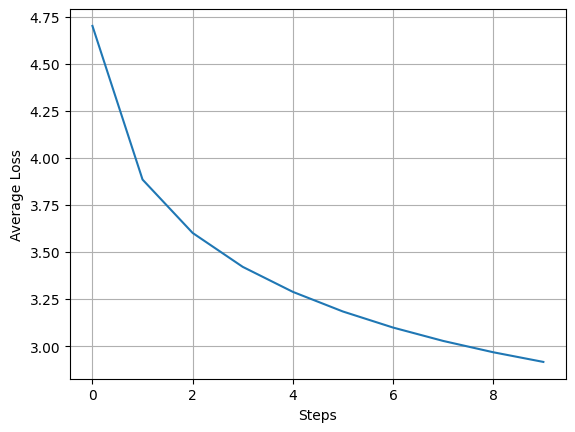

In [18]:
import matplotlib.pyplot as plt

# plotting loss history
plt.plot(loss_history)
plt.xlabel("Steps")
plt.ylabel("Average Loss")
plt.grid(True)
plt.show()

In [19]:
# Saving model
torch.save(model.state_dict(), 'translator.pth')
print("Model saved as 'translator.pth'")

Model saved as 'translator.pth'


# Rough work

In [20]:
# max_words = 10
# d_model = 6

# matrix = torch.zeros(max_words, d_model)
# val = torch.Tensor([pos / (10000 ** ((2*i) / d_model)) for pos in torch.arange(max_words) for i in torch.arange(0, d_model, 2)]).reshape(max_words, d_model//2)
# matrix[:, 0::2] = torch.sin(val)
# matrix[:, 1::2] = torch.cos(val)

# print(matrix.shape)

In [21]:
# class SimpleModel(nn.Module):
#     def __init__(self, max_words, d_model):
#         super().__init__()

#         self.layer = nn.Linear(d_model, d_model//2)

#     def forward(self, x):
#         x = self.layer(x)
#         return x

In [22]:
# d_ff = 2 * d_model
# n_encoders = n_decoders = 3
# n_heads = d_model // 2

# model = MyTransformer(max_words, d_model, n_encoders, n_decoders, n_heads, d_ff)
# x = model(matrix, matrix)
# print(x)

In [23]:
# reply = list(map(lambda word : embedding_model.similar_by_vector(word, topn=1), x))
# print(reply)

In [24]:
# a = torch.Tensor([[1,2, 3, 4],
#                  [5, 6, 7, 8],
#                  [9, 10, 11, 12],
#                  [13, 14, 15, 16]])
# # soft0 = F.softmax(a, dim=-1)
# # print(soft0)
# b = a * 2
# # print(b)

# c = torch.cat((a, b), dim=1)
# print(c)